In [106]:
import pandas as pd
import numpy as np
import re
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

import seaborn as sns
sns.set_style('white')

#### corin's attempts to fit random forest to data

In [2]:
import tensorflow as tf

print(tf.__version__)  # You should see a 2.0.0 here!

import tensorflow.keras as keras

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

2.0.0


Using TensorFlow backend.


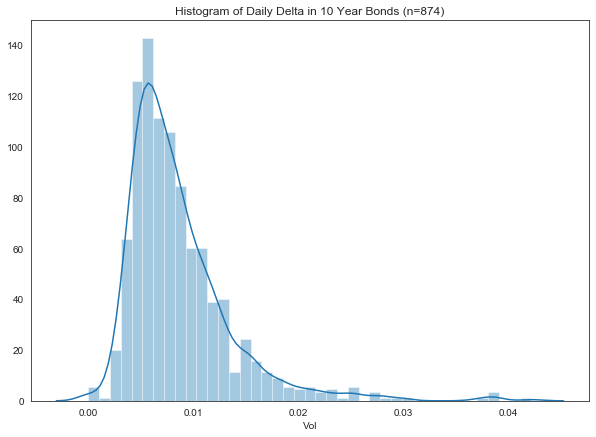

In [42]:
bonds_10 = pd.read_csv('../bonds/adjusted^TNX.csv')
bonds_10['Vol'] = (bonds_10['High'] - bonds_10['Low']) / (bonds_10['High'] + bonds_10['Low'])
#print(bonds_10.head(10))

bonds_30 = pd.read_csv('../bonds/adjusted^TYX.csv')
bonds_30['Vol'] = (bonds_30['High'] - bonds_30['Low']) / (bonds_30['High'] + bonds_30['Low'])
#print(bonds_30.head(10))

fig = plt.figure(figsize=(10,7))
sns.distplot(bonds_10['Vol'])
plt.title(f'Histogram of Daily Delta in 10 Year Bonds (n={len(bonds_10)})')

plt.show()

In [44]:
amer_stocks = pd.read_csv('../stocks/amer_stocks_delta.csv')
amer_stocks['Date'] = amer_stocks['date']

In [101]:
predictors = pd.read_csv('../tweets/cleaned_tweet_text_by_day')
#print(predictors.info())

sentiment = pd.read_csv('../tweets/data/sentiment.csv')
sentiment = sentiment.groupby([sentiment.Date]
).agg(
        {
            'sentiment': sum,
            'Date': 'first',
        }
    )
sentiment = sentiment.rename_axis(None)

#print(sentiment.info())

word2vec = pd.read_csv('../tweets/data/keyword_word2vec_predictors.by_day.csv')
#print(word2vec.info())

features = pd.read_csv('../tweets/cleaned_tweets_by_day')
#print(features.info())

handles = pd.read_csv('../tweets/data/frequent_handles.by_day.csv')
#print(handles.info())

topics = pd.read_csv('../tweets/data/topic_model_simple_weights.by_day.csv')
print(topics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 21 columns):
Date      1006 non-null object
0_sum     1006 non-null float64
1_sum     1006 non-null float64
2_sum     1006 non-null float64
3_sum     1006 non-null float64
4_sum     1006 non-null float64
5_sum     1006 non-null float64
6_sum     1006 non-null float64
7_sum     1006 non-null float64
8_sum     1006 non-null float64
9_sum     1006 non-null float64
10_sum    1006 non-null float64
11_sum    1006 non-null float64
12_sum    1006 non-null float64
13_sum    1006 non-null float64
14_sum    1006 non-null float64
15_sum    1006 non-null float64
16_sum    1006 non-null float64
17_sum    1006 non-null float64
18_sum    1006 non-null float64
19_sum    1006 non-null float64
dtypes: float64(20), object(1)
memory usage: 165.2+ KB
None


In [102]:
pred_bonds_10 = pd.merge(left=predictors, right=sentiment, on='Date') # default is INNER join which is what we want
pred_bonds_10 = pd.merge(left=pred_bonds_10, right=word2vec, on='Date')
pred_bonds_10 = pd.merge(left=pred_bonds_10, right=features, on='Date')
pred_bonds_10 = pd.merge(left=pred_bonds_10, right=handles, on='Date')
pred_bonds_10 = pd.merge(left=pred_bonds_10, right=topics, on='Date')

pred_cols = pred_bonds_10.columns.values
pred_cols = list(filter(lambda a: not re.match("Unnamed", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("Date", a), pred_cols))
#pred_cols = list(filter(lambda a: not re.match("year", a), pred_cols))
#pred_cols = list(filter(lambda a: not re.match("month", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("day", a), pred_cols))
pred_cols = list(filter(lambda a: not re.match("clean_text", a), pred_cols))

pred_bonds_10 = pd.merge(left=amer_stocks, right=pred_bonds_10, on='Date') # default is INNER join which is what we want

def add_lookback_predictors(df, columns, num_days=10):
    df.sort_values(by=['Date'])
    new_cols = copy.deepcopy(columns)
    
    for idx, row in df.iterrows():
        if idx < num_days:
            continue
        for col in columns:
            for day in range(1,num_days+1):
                new_cols.append(f"{col}_{day}")
                df.loc[idx, f"{col}_{day}"] = df.loc[idx-day, col]
    
    return df[new_cols]
        
num_days = 5
#pred_cols2 = add_lookback_predictors(pred_bonds_10, pred_cols, num_days=num_days)
pred_cols2 = pred_bonds_10
print(pred_cols2[-20:])
#print(pred_cols)
#pred_bonds_10.columns.values

     Unnamed: 0  DE.Adjusted  SOYB.Adjusted  CORN.Adjusted  BBY.Adjusted  \
673         692     0.061901      -0.044394       0.023899      0.053647   
674         693     0.110555       0.044394      -0.055838      0.101648   
675         694    -0.043840       0.029501       0.039911     -0.005734   
676         695    -0.061259       0.036771       0.181911     -0.127703   
677         696     0.056627       0.036654      -0.023573      0.035124   
678         697     0.052687       0.007317      -0.310706      0.085197   
679         698     0.119526       0.094701       0.373465      0.225121   
680         699    -0.076393       0.057894      -0.039186     -0.064179   
681         700     0.139615      -0.043393      -0.055075     -0.062521   
682         701    -0.059088      -0.072687      -0.007888      0.037758   
683         702     0.040448       0.021854       0.070810      0.116441   
684         703     0.066114       0.043584      -0.070810      0.049933   
685         

In [168]:
print(len(pred_bonds_10))
num_days = 0
col = 'combined'

pred_bonds_10[col] = pred_bonds_10[col] - np.min(pred_bonds_10[col])
pred_bonds_10[col] = pred_bonds_10[col] / np.max(pred_bonds_10[col])
pred_bonds_10[col] = 2 * (pred_bonds_10[col] - 0.5)

full_test = pred_bonds_10[(596+num_days):693]
full_train = pred_bonds_10[num_days:595]

Xt = full_test[pred_cols].to_numpy()
yt = full_test[col].to_numpy() # vol for bonds

X = full_train[pred_cols].to_numpy()
y = full_train[col].to_numpy()

scale = StandardScaler().fit(X)

X = scale.transform(X)

X_orig = copy.deepcopy(X)
y_orig = copy.deepcopy(y)

for n in range(5):
    random_noise = np.random.normal(0, 0.2, X_orig.shape)
    X = np.vstack((X, X_orig + random_noise))
    y = np.hstack((y, y_orig))
    

Xt = scale.transform(Xt)

print(X_orig.shape)
print(X.shape)
print(y_orig.shape)
print(y.shape)

#### adapted from https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

693
(595, 315)
(3570, 315)
(595,)
(3570,)


In [170]:
kernel_reg = tf.keras.regularizers.l1_l2(l1=0.00005, l2=0.01)
#kernel_reg = tf.keras.regularizers.l1_l2(l1=0.00003, l2=0.001)
dropout_c = 0.3

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(X[0]),)))
model.add(Dropout(dropout_c))
#model.add(BatchNormalization())
#model.add(Dense(32, activation='relu', kernel_regularizer=kernel_reg,))
model.add(Dropout(dropout_c))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=kernel_reg,))
model.add(Dropout(dropout_c))
model.add(Dense(64, activation='relu', kernel_regularizer=kernel_reg,))
#model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam')

print(model.summary())
history = model.fit(X, y, epochs=200, batch_size=32, verbose=1, validation_split=0.1)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 64)                20224     
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_150 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_83 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_152 (Dense)            (None, 1)               

Epoch 66/200
3213/3213 [==============================] - 1s 178us/step - loss: 0.0808 - val_loss: 0.0702
Epoch 67/200
3213/3213 [==============================] - 1s 183us/step - loss: 0.0830 - val_loss: 0.0757
Epoch 68/200
3213/3213 [==============================] - 1s 159us/step - loss: 0.0810 - val_loss: 0.0678
Epoch 69/200
3213/3213 [==============================] - 1s 162us/step - loss: 0.0804 - val_loss: 0.0793
Epoch 70/200
3213/3213 [==============================] - 1s 161us/step - loss: 0.0803 - val_loss: 0.0677
Epoch 71/200
3213/3213 [==============================] - 1s 158us/step - loss: 0.0808 - val_loss: 0.0677
Epoch 72/200
3213/3213 [==============================] - 1s 158us/step - loss: 0.0796 - val_loss: 0.0681
Epoch 73/200
3213/3213 [==============================] - 1s 159us/step - loss: 0.0788 - val_loss: 0.0701
Epoch 74/200
3213/3213 [==============================] - 1s 159us/step - loss: 0.0808 - val_loss: 0.0708
Epoch 75/200
3213/3213 [======================

Epoch 143/200
3213/3213 [==============================] - 1s 158us/step - loss: 0.0675 - val_loss: 0.0632
Epoch 144/200
3213/3213 [==============================] - 1s 159us/step - loss: 0.0683 - val_loss: 0.0568
Epoch 145/200
3213/3213 [==============================] - 1s 158us/step - loss: 0.0662 - val_loss: 0.0579
Epoch 146/200
3213/3213 [==============================] - 1s 158us/step - loss: 0.0677 - val_loss: 0.0690
Epoch 147/200
3213/3213 [==============================] - 1s 174us/step - loss: 0.0680 - val_loss: 0.0579
Epoch 148/200
3213/3213 [==============================] - 1s 221us/step - loss: 0.0660 - val_loss: 0.0603
Epoch 149/200
3213/3213 [==============================] - 1s 207us/step - loss: 0.0663 - val_loss: 0.0564
Epoch 150/200
3213/3213 [==============================] - 1s 169us/step - loss: 0.0678 - val_loss: 0.0663
Epoch 151/200
3213/3213 [==============================] - 1s 195us/step - loss: 0.0656 - val_loss: 0.0631
Epoch 152/200
3213/3213 [============

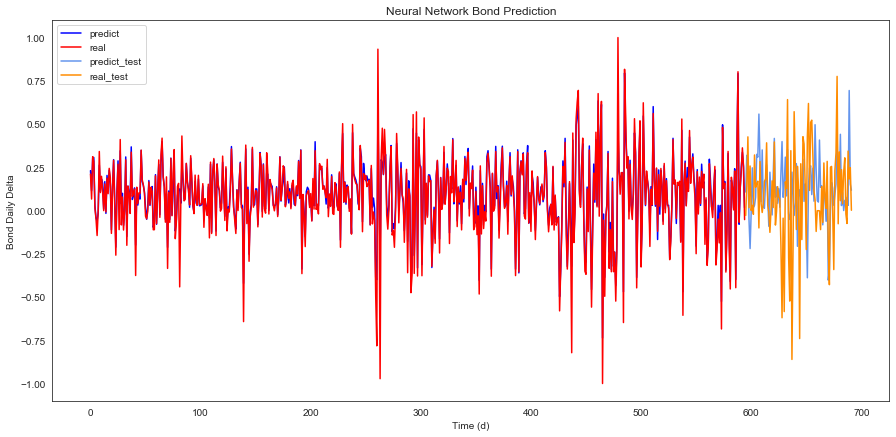

In [171]:
fig = plt.figure(figsize=(15,7))

pred_y = model.predict(X_orig, verbose=0)
pred_yt = model.predict(Xt, verbose=0)

plt.title('Neural Network Bond Prediction')
plt.ylabel('Bond Daily Delta')
plt.xlabel('Time (d)')

plt.plot(range(len(y_orig)), pred_y, c='b', label='predict')
plt.plot(range(len(y_orig)), y_orig, c='r', label='real')
plt.plot(range(len(y_orig),len(yt)+len(y_orig)), pred_yt, c='cornflowerblue', label='predict_test')
plt.plot(range(len(y_orig),len(yt)+len(y_orig)), yt, c='darkorange', label='real_test')

plt.legend(loc='best')
plt.show()

0.0616
0.0603
0.2405
0.2599 (5%: 0.2384, 95%: 0.2794)
7.48%


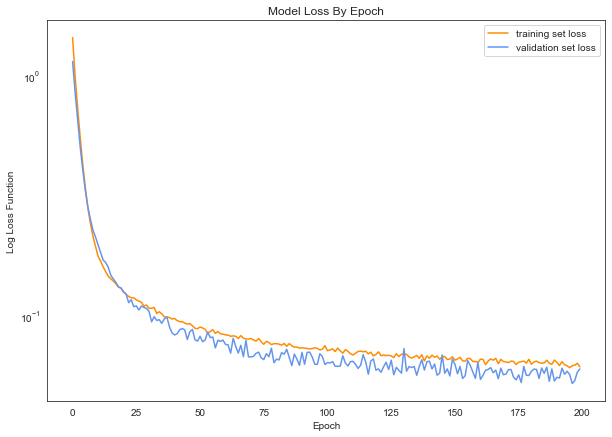

In [177]:
def plot_history(history, ax):
    ax.set_yscale("log", nonposy='clip')
    ax.plot(range(len(history.history['loss'])), history.history['loss'], color='darkorange', label='training set loss')
    ax.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='cornflowerblue', label='validation set loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log Loss Function')
    ax.set_title('Model Loss By Epoch')
    ax.legend(loc='best')
    
figure = plt.figure(figsize=(10,7))

print(f"{history.history['loss'][-1]:.4f}")
print(f"{history.history['val_loss'][-1]:.4f}")
print(f"{model.evaluate(Xt, yt, verbose=0):.4f}")

rand_vals = []
for x in range(1000):
    rand_yt = np.array(copy.deepcopy(yt))
    np.random.shuffle(rand_yt)
    rand_vals.append(model.evaluate(Xt, rand_yt, verbose=0))
    
sorted_vals = np.sort(rand_vals)
print(f"{np.mean(rand_vals):.4f} (5%: {sorted_vals[50]:.4f}, 95%: {sorted_vals[950]:.4f})")


print(f"{(1-model.evaluate(Xt, yt, verbose=0)/np.mean(rand_vals))*100:.2f}%")

plot_history(history, figure.gca())
plt.show()